In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.datasets import ImageNet
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F

In [12]:
# USE CNN that is pretrained on cifar10
from cifar10_models.resnet import *

model = resnet18()
weights = torch.load('state_dicts/resnet18.pt')
model.load_state_dict(weights)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Check labels of class

In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

mean = (0.4914, 0.4822, 0.4465)
std = (0.2471, 0.2435, 0.2616)

transform = transforms.Compose([
    # transforms.Resize((crop_resolution, crop_resolution)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

cifar10_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
loader = DataLoader(cifar10_dataset, batch_size=1000, shuffle=True)


cifar10_classes = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

Files already downloaded and verified


# Our Classmaximization Method (with gaussian blur)

In [5]:
class ClassMaxim(nn.Module):
    def __init__(self):
        super(ClassMaxim, self).__init__()
        self.x_c = nn.parameter.Parameter(torch.randn(1, 3, 32, 32))  
        self.clone = self.x_c.clone()

In [10]:
from torchvision.transforms.functional import gaussian_blur
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

In [37]:
clsmax = ClassMaxim()
clss = 9 # billard class

# hyperparameters
lamb = 0.1
lr = 4
sigma = 0.5
kern_size = 3
blur_frequency = 4

In [38]:
from torchvision.transforms.functional import gaussian_blur
def gaussian_blur_channelwise(input_tensor, kernel_size, sigma):
    channels = 3
    blurred_channels = []
    for c in range(channels):
        blurred_channel = gaussian_blur(input_tensor[:, c:c+1, :, :], kernel_size=kernel_size, sigma=sigma)
        blurred_channels.append(blurred_channel)
    return torch.cat(blurred_channels, dim=1)

<Figure size 640x480 with 0 Axes>

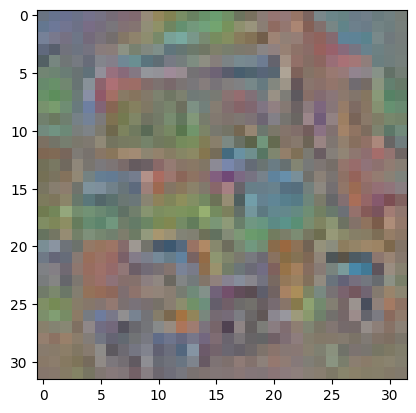

In [39]:
std_tens = torch.tensor(std).reshape(-1,1,1)
mean_tens = torch.tensor(mean).reshape(-1,1,1)

plt.figure()
for i in range(40):
    # lr-=2
    # if lr <= 8:
    #     lr = 8
    plt.imshow((clsmax.x_c[0]*std_tens + mean_tens).detach().numpy().transpose(1,2,0))
    plt.show()
    for step in range(20):
        xx = clsmax.x_c[0]
        preds = model(xx.unsqueeze(0)) # cnn 1 x 3 x 32 x 32, expected dim
        preds = preds.squeeze(0)

        loss = (preds[clss] - lamb*(torch.norm(clsmax.x_c[0],p=2)))
        (loss).backward()
        
        grad = clsmax.x_c.grad #/ (torch.norm(clsmax.x_c.grad)+ 1e-5) # l2 norm, grads
        clsmax.x_c = nn.Parameter(clsmax.x_c + grad*lr) # update step, gradient ascent

        with torch.no_grad():
            # normalize between 0 and 1
            min_value = torch.min(clsmax.x_c)
            max_value = torch.max(clsmax.x_c)
            normalized_tensor = (clsmax.x_c - min_value) / (max_value - min_value)
            blurred_tensor = normalized_tensor

            # Gaussian blur
            if step % blur_frequency == 0:
                blurred_tensor = gaussian_blur_channelwise(normalized_tensor, kernel_size=kern_size, sigma=sigma)
            
            # clipping pixels with small norm
            clipped_tensor = blurred_tensor
            norms = torch.norm(blurred_tensor, dim=1, p=2)
            below_threshold = norms < 0.001
            blurred_tensor[:, :, below_threshold.squeeze(0)] = 0
            clsmax.x_c = nn.Parameter(clipped_tensor  * (max_value - min_value) + min_value)
    
    if(i < 39):
        clear_output(wait=True)
        display(plt.gcf())


In [6]:
from torchvision.transforms.functional import gaussian_blur
def gaussian_blur_channelwise(input_tensor, kernel_size, sigma):
    channels = 3
    blurred_channels = []
    for c in range(channels):
        blurred_channel = gaussian_blur(input_tensor[:, c:c+1, :, :], kernel_size=kernel_size, sigma=sigma)
        blurred_channels.append(blurred_channel)
    return torch.cat(blurred_channels, dim=1)

In [7]:
normalize = transforms.Normalize(mean, std)

def clamp_to_img(x):
  return torch.clamp(x, min=0., max=1.)

In [47]:
def activation_maxim(model, label, lamb, alpha, iters, device="cpu"):
  sigma = 1
  kernel_size=3
  image = torch.randn(1, 3, 32, 32).to(device)
  r = torch.rand_like(image).to(device)
  r.requires_grad_()

  for i in range(iters):
      preds = model(normalize(r)) #clamp_to_img(r)
      loss = preds[0,label] - lamb*(torch.norm(r,p=2))
      (-loss).backward()
      r.data -=  alpha * r.grad.data
      
      if i % 4 == 0:
        with torch.no_grad():
          r.data = gaussian_blur_channelwise(r, kernel_size, sigma)
          sigma*=0.99
          if sigma < 0.5:
             sigma = 0.5
          norms = torch.norm(r, dim=1, p=2)
          below_threshold = norms < 0.0001
          r.data[:, :, below_threshold.squeeze(0)] = 0
        if i%20==0:
          image_np = clamp_to_img(r.detach())[0].permute(1, 2, 0).cpu().numpy()
          clear_output(wait=True)
          display(plt.gcf())
          plt.imshow(image_np)
          plt.axis('off')
          plt.show()

  output_image = clamp_to_img(r)
  return output_image

<Figure size 640x480 with 0 Axes>

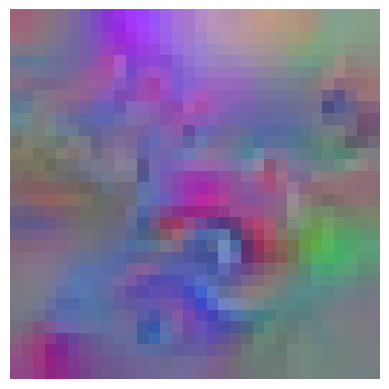

tensor([[[[0.6230, 0.6060, 0.5808,  ..., 0.5133, 0.5395, 0.5325],
          [0.6259, 0.6066, 0.5765,  ..., 0.5172, 0.5331, 0.5301],
          [0.6117, 0.5803, 0.5536,  ..., 0.5307, 0.5260, 0.5209],
          ...,
          [0.5603, 0.5511, 0.6176,  ..., 0.4578, 0.4709, 0.4677],
          [0.5492, 0.5740, 0.6246,  ..., 0.4539, 0.4637, 0.4674],
          [0.5417, 0.5747, 0.6083,  ..., 0.4545, 0.4598, 0.4626]],

         [[0.3805, 0.3797, 0.4285,  ..., 0.6341, 0.6308, 0.6135],
          [0.3921, 0.3911, 0.4375,  ..., 0.6359, 0.6299, 0.6184],
          [0.4319, 0.4216, 0.4555,  ..., 0.6157, 0.6070, 0.6023],
          ...,
          [0.3426, 0.2792, 0.2330,  ..., 0.4972, 0.4948, 0.4923],
          [0.3001, 0.2771, 0.2074,  ..., 0.5012, 0.4968, 0.4957],
          [0.2772, 0.2691, 0.2084,  ..., 0.5033, 0.4960, 0.4930]],

         [[0.4926, 0.4811, 0.4940,  ..., 0.5551, 0.5408, 0.5252],
          [0.4928, 0.4796, 0.4941,  ..., 0.5497, 0.5436, 0.5364],
          [0.4946, 0.4728, 0.4988,  ..., 0

In [48]:
activation_maxim(model, 1, lamb=0.0005, alpha=0.0005, iters=1000, device="cpu")